In [1]:
import glob, os
import json
import nemo
import torch
import librosa
import numpy as np
import random
import IPython.display as ipd

from pathlib import Path
from tqdm.notebook import tqdm
from nemo.collections.tts.models import HifiGanModel, FastPitchModel
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
from nemo.collections.tts.models import HifiGanModel, FastPitchModel

[NeMo W 2023-07-17 12:57:05 experimental:27] Module <class 'nemo.collections.asr.modules.audio_modules.SpectrogramToMultichannelFeatures'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-07-17 12:57:05 experimental:27] Module <class 'nemo.collections.tts.models.fastpitch_ssl.FastPitchModel_SSL'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-07-17 12:57:05 experimental:27] Module <class 'nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.IPATokenizer'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-07-17 12:57:05 experimental:27] Module <class 'nemo.collections.tts.models.radtts.RadTTSModel'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-07-17 12:57:06 experimental:27] Module <class 'nemo.collections.tts.models.ssl_tts.SSLDisentangler'> is expe

In [2]:
test = "El viento y el Sol discutían su poder sobre los hombres y decidieron establecer una apuesta entre ellos para ver quién retiraba la ropa de un hombre en menor tiempo. El viento comenzó en primer lugar sobre un monje que iba por el bosque y soplando con gran fuerza vio que no era suficiente, así que provocó un vendaval, lo que hizo que el monje buscara un abrigo en la alforja de su mula para protegerse."
# test = "En un lugar de la Mancha, de cuyo nombre no quiero acordarme, no ha mucho que vivía un hidalgo."
# test = "Un niño, ñoño, lloraba porque quería una piruleta. Se fue corriendo."
# test = "Mariana Magaña desenmarañará mañana la maraña que enmarañara Mariana Mañara."
test_id = "19demarzo_3262" # identifier for the audio corresponding to the test text
data_path = "/home/irene/datasets/datasetCastellanoReducido/19demarzo/" # path to dataset folder with wav files from original dataset

In [3]:
os.chdir("/home/irene/datasets")
file_list = glob.glob("NemoSpanishTTS/resultSpanishTTS/FastPitch/2023-06-28_18-47-07/checkpoints/*")
fastpitch_model_path = sorted(file_list, key=os.path.basename)[0] # path_to_fastpitch_nemo_or_ckpt
hfg_path = sorted(glob.glob("NemoSpanishTTS/resultSpanishTTS/HifiGan/2023-07-17_11-14-54/checkpoints/HifiGan.nemo"), key=os.path.getmtime)[-1]

if ".nemo" in hfg_path:
    vocoder_model_pt = HifiGanModel.restore_from(hfg_path).eval().cuda()
else:
    vocoder_model_pt = HifiGanModel.load_from_checkpoint(checkpoint_path=hfg_path).eval().cuda()

if ".nemo" in fastpitch_model_path:
    spec_gen_model = FastPitchModel.restore_from(fastpitch_model_path).eval().cuda()
else:
    spec_gen_model = FastPitchModel.load_from_checkpoint(checkpoint_path=fastpitch_model_path).eval().cuda()

[NeMo W 2023-07-17 12:57:06 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.dataset.VocoderDataset
      manifest_filepath: train_manifest_text_normed_mel.json
      sample_rate: 22050
      n_segments: 8192
      max_duration: null
      min_duration: 0.75
      load_precomputed_mel: true
      hop_length: 256
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 16
      num_workers: 4
      pin_memory: true
    
[NeMo W 2023-07-17 12:57:06 modelPT:168] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.dataset.Vo

[NeMo I 2023-07-17 12:57:06 features:291] PADDING: 0
[NeMo I 2023-07-17 12:57:06 features:299] STFT using exact pad
[NeMo I 2023-07-17 12:57:06 features:291] PADDING: 0
[NeMo I 2023-07-17 12:57:06 features:299] STFT using exact pad


[NeMo I 2023-07-17 12:57:07 save_restore_connector:249] Model HifiGanModel was successfully restored from /home/irene/datasets/NemoSpanishTTS/resultSpanishTTS/HifiGan/2023-07-17_11-14-54/checkpoints/HifiGan.nemo.


[NeMo W 2023-07-17 12:57:43 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.dataset.TTSDataset
      manifest_filepath: train_manifest_text_normed.json
      sample_rate: 22050
      sup_data_path: sup_data
      sup_data_types:
      - align_prior_matrix
      - pitch
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: null
      max_duration: 15
      min_duration: 0.1
      ignore_file: null
      trim: true
      trim_top_db: 50
      trim_frame_length: 1024
      trim_hop_length: 256
      pitch_fmin: 65.40639132514966
      pitch_fmax: 2093.004522404789
      pitch_norm: true
      pitch_mean: 126.73465728759766
      pitch_std: 38.099849700927734
    dataloader_params:
      drop_last: false
   

[NeMo I 2023-07-17 12:57:43 features:291] PADDING: 1


In [4]:
def evaluate_spec_fastpitch_ckpt(spec_gen_model, v_model, test, speaker=None):
    seed = random.randint(100000, 999999)
#   print(seed)
    with torch.no_grad():
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.enabled = True
        torch.backends.cudnn.benchmark = False
        parsed = spec_gen_model.parse(str_input=test, normalize=True)
        if speaker == None:
            spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed)
        else:
            spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed, speaker=speaker)
        print(spectrogram.size())
        audio = v_model.convert_spectrogram_to_audio(spec=spectrogram)

    spectrogram = spectrogram.to('cpu').numpy()[0]
    audio = audio.to('cpu').numpy()[0]
    audio = audio / np.abs(audio).max()
    return audio, spectrogram

torch.Size([1, 80, 1684])


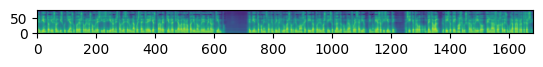

original audio


predicted audio


In [5]:
%matplotlib inline

audio, spectrogram = evaluate_spec_fastpitch_ckpt(spec_gen_model, vocoder_model_pt, test)

# visualize the spectrogram
if spectrogram is not None:
    imshow(spectrogram, origin="lower")
    plt.show()

# audio
print("original audio")
ipd.display(ipd.Audio(data_path+test_id+'.wav', rate=22050))
print("predicted audio")
ipd.display(ipd.Audio(audio, rate=22050))